# Transformer-based embedding of posts from cancer patients

### Data
A collection of a little over 10,000 posts from cancer patients and their caregivers on platforms like Reddit, Daily Strength, and the Health Board were analyzed using a transformer-based neural network to generate a high-dimensional embedding vector space for visualizing and identifying the similarities and dissimilarities between the various posts. This analysis has the potential to provide insights on the emotional aspects of cancer patients posts for a mental health study.

### Neural network 
##### TSDAE (Transformer-based Sequential Denoising Auto-Encoder)
TSDAE is an unsupervised sentence embedding learning method. Further details of this network can be found on this paper: https://arxiv.org/abs/2104.06979

### Important libraries
1) PyTorch (https://pytorch.org)
2) Sentence Transformers (https://www.sbert.net)


In [1]:
# Importing libraries
from torch.utils.data import DataLoader
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import pandas as pd
import os, sys
# from os.path import join
# from sklearn.metrics import f1_score, balanced_accuracy_score
# from sklearn.model_selection import train_test_split
import numpy as np
import sklearn
from datasets import Dataset, DatasetDict
import torch
# from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, InputExample, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from torch.utils.data import DataLoader
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\halde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\halde\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\halde\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Prepare data
### Import data
Over 10,000 posts from cancer patients and their caregivers on platforms like Reddit, Daily Strength, and the Health Board were collected (More details about the dataset as well as the datset can be found here: https://www.kaggle.com/datasets/irinhoque/mental-health-insights-vulnerable-cancer-patients). The posts were related to five types of cancer: brain, colon, liver, leukemia, and lung cancer. Two team members scored each post based on the emotions expressed, using a scale from -2 to 1. Negative scores (-1 or -2) were given for posts showing grief or suffering, positive scores (1) for happy emotions like relief or accomplishment, and posts with no emotion received a score of 0 and were considered neutral. 

In [2]:
df = pd.read_csv("Mental Health Dataset.csv")
df.head()

,posts,predicted,intensity
0,I know as parent of child with down syndrome t...,negative,-1
1,but in my heart I know this is the future prom...,neutral,0
2,I have mylefibrosis which turn to leukemia the...,negative,-1
3,from one of my health group subject wayne dyer...,neutral,0
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0


### Cleaning the data
1) Drop the columns not necessary for this analysis. 
2) Remove rows with no entries.
3) Renumber the labels

In [3]:
# Interger labels in the dataset
df['intensity'].unique()

array([-1,  0,  1, -2], dtype=int64)

In [4]:
df['input'] = df['posts']
df.loc[df['intensity']==-2,'labels'] = 0 # Very negative
df.loc[df['intensity']==-1,'labels'] = 1 # Negative
df.loc[df['intensity']==0,'labels'] = 2 # Neutral
df.loc[df['intensity']==1,'labels'] = 3 # Positive
df['labels'] = df['labels'].astype('int')
df.drop(columns=['posts','predicted','intensity'],inplace=True)
df = df.dropna(how='any').reset_index()
df.head()

,index,input,labels
0,0,I know as parent of child with down syndrome t...,1
1,1,but in my heart I know this is the future prom...,2
2,2,I have mylefibrosis which turn to leukemia the...,1
3,3,from one of my health group subject wayne dyer...,2
4,4,gmos now link to leukemia http nsnbc I 2013 07...,2


### Visualizing the data distribution

In [5]:
df_pie = df['labels'].value_counts()
df_pie.head()

2    4374
1    4112
0    1155
3     750
Name: labels, dtype: int64

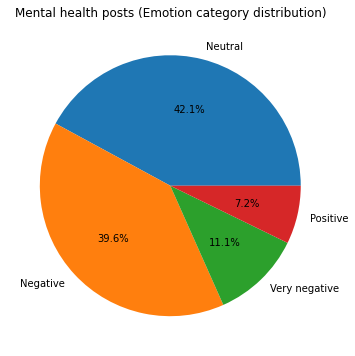

In [6]:
# Brief summary of the data
labels = ['Neutral','Negative','Very negative','Positive']
# sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(df_pie, labels=labels, autopct='%1.1f%%')
plt.title('Mental health posts (Emotion category distribution)')
plt.show()

In [7]:
input_list = df['input'].to_list()

## TSDAE: Transformer-based Sequential Denoising Auto-Encoder
Wang K, Reimers N, Gurevych I. TSDAE: Using Transformer-based Sequential Denoising Auto-Encoder for Unsupervised Sentence Embedding Learning, In Conference on Empirical Methods in Natural Language Processing, 2021.

Paper link: https://arxiv.org/abs/2104.06979

TSDAE is an unsupervised sentence embedding learning method.


In [8]:
# Define your sentence transformer model using CLS pooling
model_name = 'bert-base-uncased'
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [9]:
# Special denoising dataset that adds noise on-the-fly
train_dataset = datasets.DenoisingAutoEncoderDataset(input_list)

# DataLoader for batch data
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [10]:
# Define denoising auto-encoder loss
train_loss = losses.DenoisingAutoEncoderLoss(model, decoder_name_or_path=model_name, tie_encoder_decoder=True)

When tie_encoder_decoder=True, the decoder_name_or_path will be invalid.
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.5.crossattention.output.dense.bias', 'bert.encoder.layer.4.crossattention.self.key.weight', 'bert.encoder.layer.9.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.6.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.10.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.self.key.weight', 'bert.encoder.layer.9.crossattention.output.dense.bias', 'bert.encoder.layer.6.crossattention.output.dense.bias', 'bert.encoder.layer.5.crossattention.self.query.bias', 'bert.encoder.layer.10.crossattention.output.dense.weight', 'bert.encoder.layer.2.crossattention.self.query.weight', 'bert.encoder.layer.8.crossattention.self.key.weight', 'bert.encoder.layer.4.crossattention.output.Laye

In [11]:
# Call the fit method
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=10,
    weight_decay=0,
    scheduler='constantlr',
    optimizer_params={'lr': 2e-5},
    show_progress_bar=True
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2598 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Iteration:   0%|          | 0/2598 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2598 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2598 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2598 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2598 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2598 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2598 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2598 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2598 [00:00<?, ?it/s]

In [12]:
# Save the model
model.save('tsdae-model')

## Embeddings in a 768-dimensional space

In [13]:
sentence_embeddings = model.encode(input_list)
sentence_embeddings.shape

(10391, 768)

## Visualization

#### Linear Discriminant Analysis (LDA)
LDA was used reduced the 768-dimensional embedding space to a 3-dimensional space using the four labels: positive, neutral, negetive, very negetive

In [14]:
groups = df['labels'].to_numpy()
groups = np.squeeze(groups)

In [15]:
groups.shape

(10391,)

In [16]:
lda = LDA(n_components=3)
lda.fit(sentence_embeddings, groups)
z_lda = lda.transform(sentence_embeddings)

In [17]:
z_lda.shape

(10391, 3)

(-5.0, 4.0)

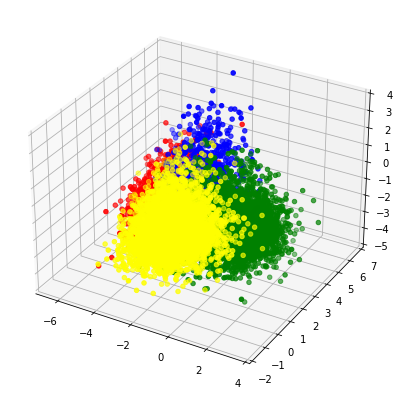

In [28]:
pos_0 = np.where(groups==0)[0]
pos_1 = np.where(groups==1)[0]
pos_2 = np.where(groups==2)[0]
pos_3 = np.where(groups==3)[0]
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(z_lda[pos_3,0],z_lda[pos_3,1], z_lda[pos_3,2], color = "blue")
ax.scatter3D(z_lda[pos_2,0],z_lda[pos_2,1], z_lda[pos_2,2], color = "green")
ax.scatter3D(z_lda[pos_1,0],z_lda[pos_1,1], z_lda[pos_1,2], color = "yellow")
ax.scatter3D(z_lda[pos_0,0],z_lda[pos_0,1], z_lda[pos_0,2], color = "red")
ax.set_xlim([-7,4])
ax.set_ylim([-2,7])
ax.set_zlim([-5,4])

In [19]:
from scipy import io
io.savemat('mh_embeddings.mat',{'z_lda':z_lda,'sentence_embeddings':sentence_embeddings})